In [43]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

In [99]:
LABELS = 10 # Number of different types of labels (1-10)
WIDTH = 28 # width / height of the image
CHANNELS = 1 # Number of colors in the image (greyscale)

VALID = 10000 # Validation data size

STEPS = 3000 # Number of steps to run
BATCH = 200 #250 #150 Stochastic Gradient Descent batch size
PATCH = 5 # Convolutional Kernel size
DEPTH = 8 #16 #Convolutional Kernel depth size == Number of Convolutional Kernels
HIDDEN = 100 # Number of hidden neurons in the fully connected layer

LR = 0.001 # Learning rate

## Import data
- one-hot encoding
- split data into train & validation

In [84]:
# read csv file in pandas dataframe
data = pd.read_csv('../final/train.csv')

# 預測目標Y的轉換
labels = np.array(data.pop('label')) 
labels = LabelEncoder().fit_transform(labels)[:, None]
labels = OneHotEncoder().fit_transform(labels).todense()

# 保存data中的參數
# reshape data into 2-D images
data = StandardScaler().fit_transform(np.float32(data.values)) 
data = data.reshape(-1, WIDTH, WIDTH, CHANNELS) 

# split data into train and validation
train_data, valid_data = data[:-VALID], data[-VALID:]
train_labels, valid_labels = labels[:-VALID], labels[-VALID:]

print('train data shape = ' + str(train_data.shape) + ' = (TRAIN, WIDTH, WIDTH, CHANNELS)')
print('labels shape = ' + str(train_labels.shape) + ' = (TRAIN, LABELS)')

train data shape = (32000, 28, 28, 1) = (TRAIN, WIDTH, WIDTH, CHANNELS)
labels shape = (32000, 10) = (TRAIN, LABELS)


## Model
- build 2 convolution layers, followed by one fully conected layer

In [100]:
# placeholder 為可以讓 computational graph保留輸入欄位的節點(tensor)
# 放x的tensor
tf_data = tf.placeholder(tf.float32, shape=(None, WIDTH, WIDTH, CHANNELS))
# 放y的tensor
tf_labels = tf.placeholder(tf.float32, shape=(None, LABELS))

In [101]:
# 2 convolution layers
w1 = tf.Variable(tf.truncated_normal([PATCH, PATCH, CHANNELS, DEPTH], stddev=0.1))
b1 = tf.Variable(tf.zeros([DEPTH]))
w2 = tf.Variable(tf.truncated_normal([PATCH, PATCH, DEPTH, 2*DEPTH], stddev=0.1))
b2 = tf.Variable(tf.constant(1.0, shape=[2*DEPTH]))

# fully connected hidden layer
w3 = tf.Variable(tf.truncated_normal([WIDTH // 4 * WIDTH // 4 * 2*DEPTH, HIDDEN], stddev=0.1))
b3 = tf.Variable(tf.constant(1.0, shape=[HIDDEN]))

# output layer
w4 = tf.Variable(tf.truncated_normal([HIDDEN, LABELS], stddev=0.1))
b4 = tf.Variable(tf.constant(1.0, shape=[LABELS]))

def logits(data):
    # Convolutional layer 1
    x = tf.nn.conv2d(data, w1, [1, 1, 1, 1], padding='SAME')
    x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    x = tf.nn.relu(x + b1) #activation function
    # Convolutional layer 2
    x = tf.nn.conv2d(x, w2, [1, 1, 1, 1], padding='SAME')
    x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    x = tf.nn.relu(x + b2)
    # Fully connected layer
    x = tf.reshape(x, (-1, WIDTH // 4 * WIDTH // 4 * 2*DEPTH))
    x = tf.nn.relu(tf.matmul(x, w3) + b3)
    
    return tf.matmul(x, w4) + b4 #矩陣相乘

# Prediction:
tf_pred = tf.nn.softmax(logits(tf_data))

In [102]:
# use the categorical cross entropy loss for training model
tf_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits(tf_data), labels=tf_labels))
tf_acc = 100 * tf.reduce_mean(tf.to_float(tf.equal(tf.argmax(tf_pred, 1), tf.argmax(tf_labels, 1))))

# 優化算法的決定
#tf_opt = tf.train.GradientDescentOptimizer(LR)
#tf_opt = tf.train.AdamOptimizer(LR)
tf_opt = tf.train.RMSPropOptimizer(LR)
tf_step = tf_opt.minimize(tf_loss)

## Scoring_Train

In [104]:
init = tf.global_variables_initializer()
session = tf.Session()
session.run(init)

In [105]:
from __future__ import print_function

In [36]:
#batch= 100
ss = ShuffleSplit(n_splits=STEPS, train_size=BATCH)
ss.get_n_splits(train_data, train_labels)
history = [(0, np.nan, 10)] # Initial Error Measures
for step, (idx, _) in enumerate(ss.split(train_data,train_labels), start=1):
    fd = {tf_data:train_data[idx], tf_labels:train_labels[idx]}
    session.run(tf_step, feed_dict=fd)
    if step%500 == 0:
        fd = {tf_data:valid_data, tf_labels:valid_labels}
        valid_loss, valid_accuracy = session.run([tf_loss, tf_acc], feed_dict=fd)
        history.append((step, valid_loss, valid_accuracy))
        print ('Step %i \t Valid. Acc. = %f'%(step, valid_accuracy), end='\n')

Step 500 	 Valid. Acc. = 98.459999
Step 1000 	 Valid. Acc. = 98.379997
Step 1500 	 Valid. Acc. = 98.360001
Step 2000 	 Valid. Acc. = 98.470001
Step 2500 	 Valid. Acc. = 98.529999
Step 3000 	 Valid. Acc. = 98.479996
Step 3500 	 Valid. Acc. = 98.500000


In [49]:
# batch = 200, depth= 8
ss1 = ShuffleSplit(n_splits=STEPS, train_size=BATCH)
ss1.get_n_splits(train_data, train_labels)
history = [(0, np.nan, 10)] # Initial Error Measures
for step, (idx, _) in enumerate(ss1.split(train_data,train_labels), start=1):
    fd = {tf_data:train_data[idx], tf_labels:train_labels[idx]}
    session.run(tf_step, feed_dict=fd)
    if step%500 == 0:
        fd = {tf_data:valid_data, tf_labels:valid_labels}
        valid_loss, valid_accuracy = session.run([tf_loss, tf_acc], feed_dict=fd)
        history.append((step, valid_loss, valid_accuracy))
        print ('Step %i \t Valid. Acc. = %f'%(step, valid_accuracy), end='\n')

Step 500 	 Valid. Acc. = 98.540001
Step 1000 	 Valid. Acc. = 98.540001
Step 1500 	 Valid. Acc. = 98.540001
Step 2000 	 Valid. Acc. = 98.529999
Step 2500 	 Valid. Acc. = 98.529999
Step 3000 	 Valid. Acc. = 98.529999


In [106]:
# batch = 200, depth= 16
ss4 = ShuffleSplit(n_splits=STEPS, train_size=BATCH)
ss4.get_n_splits(train_data, train_labels)
history = [(0, np.nan, 10)] # Initial Error Measures
for step, (idx, _) in enumerate(ss4.split(train_data,train_labels), start=1):
    fd = {tf_data:train_data[idx], tf_labels:train_labels[idx]}
    session.run(tf_step, feed_dict=fd)
    if step%500 == 0:
        fd = {tf_data:valid_data, tf_labels:valid_labels}
        valid_loss, valid_accuracy = session.run([tf_loss, tf_acc], feed_dict=fd)
        history.append((step, valid_loss, valid_accuracy))
        print ('Step %i \t Valid. Acc. = %f'%(step, valid_accuracy), end='\n')

Step 500 	 Valid. Acc. = 96.849998
Step 1000 	 Valid. Acc. = 97.970001
Step 1500 	 Valid. Acc. = 98.500000
Step 2000 	 Valid. Acc. = 98.589996
Step 2500 	 Valid. Acc. = 98.559998
Step 3000 	 Valid. Acc. = 98.329994


In [53]:
# batch = 250
ss2 = ShuffleSplit(n_splits=STEPS, train_size=BATCH)
ss2.get_n_splits(train_data, train_labels)
history = [(0, np.nan, 10)] # Initial Error Measures
for step, (idx, _) in enumerate(ss2.split(train_data,train_labels), start=1):
    fd = {tf_data:train_data[idx], tf_labels:train_labels[idx]}
    session.run(tf_step, feed_dict=fd)
    if step%500 == 0:
        fd = {tf_data:valid_data, tf_labels:valid_labels}
        valid_loss, valid_accuracy = session.run([tf_loss, tf_acc], feed_dict=fd)
        history.append((step, valid_loss, valid_accuracy))
        print ('Step %i \t Valid. Acc. = %f'%(step, valid_accuracy), end='\n')

Step 500 	 Valid. Acc. = 98.529999
Step 1000 	 Valid. Acc. = 98.529999
Step 1500 	 Valid. Acc. = 98.529999
Step 2000 	 Valid. Acc. = 98.519997
Step 2500 	 Valid. Acc. = 98.519997
Step 3000 	 Valid. Acc. = 98.519997


In [64]:
# batch = 150
ss3 = ShuffleSplit(n_splits=STEPS, train_size=BATCH)
ss3.get_n_splits(train_data, train_labels)
history = [(0, np.nan, 10)] # Initial Error Measures
for step, (idx, _) in enumerate(ss3.split(train_data,train_labels), start=1):
    fd = {tf_data:train_data[idx], tf_labels:train_labels[idx]}
    session.run(tf_step, feed_dict=fd)
    if step%500 == 0:
        fd = {tf_data:valid_data, tf_labels:valid_labels}
        valid_loss, valid_accuracy = session.run([tf_loss, tf_acc], feed_dict=fd)
        history.append((step, valid_loss, valid_accuracy))
        print ('Step %i \t Valid. Acc. = %f'%(step, valid_accuracy), end='\n')

Step 500 	 Valid. Acc. = 95.980003
Step 1000 	 Valid. Acc. = 97.809998
Step 1500 	 Valid. Acc. = 98.019997
Step 2000 	 Valid. Acc. = 98.540001
Step 2500 	 Valid. Acc. = 98.419998
Step 3000 	 Valid. Acc. = 98.589996


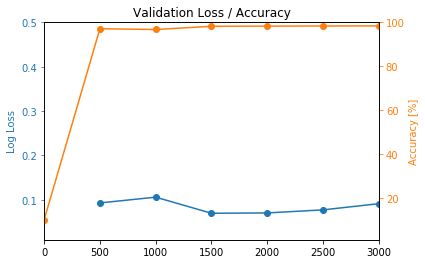

In [91]:
# 視覺化
steps, loss, acc = zip(*history)

fig = plt.figure()
plt.title('Validation Loss / Accuracy')
ax_loss = fig.add_subplot(111)
ax_acc = ax_loss.twinx()
plt.xlabel('Training Steps')
plt.xlim(0, max(steps))

ax_loss.plot(steps, loss, '-o', color='C0')
ax_loss.set_ylabel('Log Loss', color='C0');
ax_loss.tick_params('y', colors='C0')
ax_loss.set_ylim(0.01, 0.5)

ax_acc.plot(steps, acc, '-o', color='C1')
ax_acc.set_ylabel('Accuracy [%]', color='C1');
ax_acc.tick_params('y', colors='C1')
ax_acc.set_ylim(1,100)

plt.show()

## Results

In [80]:
test = pd.read_csv('../final/test.csv') # Read csv file in pandas dataframe
test_data = StandardScaler().fit_transform(np.float32(test.values)) # Convert the dataframe to a numpy array
test_data = test_data.reshape(-1, WIDTH, WIDTH, CHANNELS) # Reshape the data into 42000 2d images

In [107]:
# feed_dict: 將test_data傳入tensor（tf_data）當中
test_pred = session.run(tf_pred, feed_dict={tf_data:test_data})
test_labels = np.argmax(test_pred, axis=1)

Label Prediction: 7


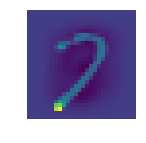

In [108]:
k = 11 # Try different image indices k
print("Label Prediction: %i"%test_labels[k])
fig = plt.figure(figsize=(2,2)); plt.axis('off')
plt.imshow(test_data[k,:,:,0]); plt.show()

In [109]:
submission = pd.DataFrame(data={'ImageId':(np.arange(test_labels.shape[0])+1), 'Label':test_labels})
submission.to_csv('submission_8.csv', index=False)
submission.tail()

,ImageId,Label
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
27999,28000,2


In [110]:
## Close Session
session.close()